In [1]:
from multiprocessing import Pool

import os
import sys
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, plot_tools, data_tools
import seaborn as sns
import openmc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from progressbar import progressbar
from tqdm import tqdm

results = []

result_folders = run_tools.get_all_result_dirs()

def handle_folder(result_folder):
    result_path = f"../results/{result_folder}"
    run_settings = run_tools.load_run_settings_json(result_path)

    statepoint_number = run_settings["active_batch_count"] + run_settings["inactive_batch_count"]
    sp = openmc.StatePoint(f"{result_path}/statepoint.{statepoint_number}.h5")

    result = {
        "k-eff": sp.keff.nominal_value, 
        "k-eff-std": sp.keff.std_dev,  
        "result_path": result_path
    }

    result.update(run_settings)
    
    return result

with Pool(32) as p:
    # Loop over each run number and get the run settings as well as the k-effective
    # for result_folder in tqdm(result_folders):
    results = list(tqdm(p.imap(handle_folder, result_folders), total=len(result_folders)))

100%|██████████| 2000/2000 [00:10<00:00, 182.64it/s]


In [8]:
# PLOT SETTINGS:
FAST_REACTOR = False # True if epithermal, False if thermal
NEUTRON_TEMP = "EPITHERMAL" if FAST_REACTOR else "THERMAL"

folder_name = f"plots-{NEUTRON_TEMP}"
os.makedirs(folder_name, exist_ok=True)

def get_filename(plot_type: str, value: str):
    return f"{folder_name}/{plot_type}_{value}-{NEUTRON_TEMP}.pdf"

# Create a dataframe from the results
df = pd.DataFrame(results)

# Filter for FAST_REACTOR
df = df[df["FAST_REACTOR"] == FAST_REACTOR]

if df.empty:
    raise Exception("No results found!")

df = data_tools.add_reactivity_to_df(df)

df.head()

,k-eff,k-eff-std,result_path,FAST_REACTOR,particle_count,active_batch_count,inactive_batch_count,t_start,t_end,t_elapsed,seed,rel_err_k-eff-std,rho,rho-std,rho-pcm,rho-std-pcm,rel-err_rho-std
0,0.988638,0.000315,../results/RUNDATA_R3_1,False,30000,300,50,1.675945e+09,1.675945e+09,130.051,2860012914,0.031853,-0.011492,0.000322,-1149.230268,32.218731,2.803505
1,0.989758,0.000320,../results/RUNDATA_R3_2,False,30000,300,50,1.675945e+09,1.675945e+09,130.224,6264270049,0.032310,-0.010348,0.000326,-1034.800618,32.643953,3.154613
2,0.989332,0.000315,../results/RUNDATA_R3_3,False,30000,300,50,1.675945e+09,1.675945e+09,129.413,9042365702,0.031845,-0.010783,0.000322,-1078.279667,32.187883,2.985115
3,0.989287,0.000316,../results/RUNDATA_R3_4,False,30000,300,50,1.675945e+09,1.675945e+09,131.589,7065801283,0.031927,-0.010829,0.000323,-1082.897195,32.273036,2.980249
4,0.989067,0.000325,../results/RUNDATA_R3_5,False,30000,300,50,1.675945e+09,1.675945e+09,134.809,6605963192,0.032905,-0.011054,0.000333,-1105.396538,33.268884,3.009679


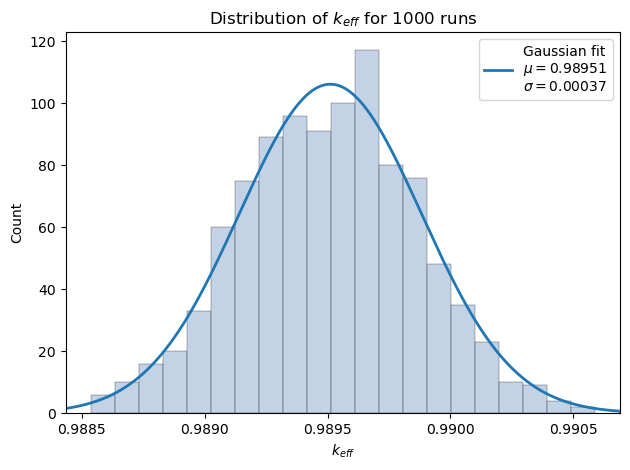

In [9]:
fig = plot_tools.plot_histogram_from_df(df=df, data_key="k-eff", 
                                        fit_gaussian=True, decimals=5,
                                        title=f"Distribution of $k_{{eff}}$ for {len(df)} runs", x_label="$k_{eff}$", y_label="Count",
                                        filename=get_filename("heatmap", "distribution-k_eff"))

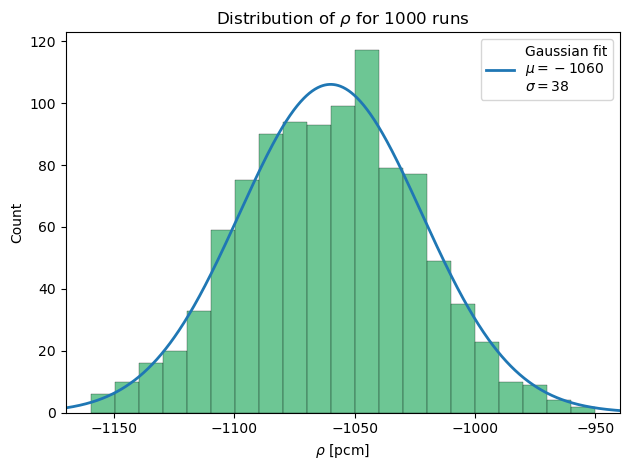

In [10]:
fig = plot_tools.plot_histogram_from_df(df=df, data_key="rho-pcm", color="mediumseagreen",
                                        fit_gaussian=True, decimals=0,
                                        title=fr"Distribution of $\rho$ for {len(df)} runs", x_label=r"$\rho$ [pcm]", y_label="Count",
                                        filename=get_filename("heatmap", "distribution-rho"))